In [2]:
import torch, torchvision
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import transforms as T
import os, shutil
from matplotlib import pyplot as plt
import sklearn as sk
from glob import glob
from tqdm import tqdm
from PIL import Image
import numpy as np
import torchmetrics
import timm
from time import time
import random
torch.cuda.is_available()

True

In [3]:
import os, gdown 
from glob import glob
import shutil
def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "brain"):

    data_nomlari = ["salaries", "exams", "college", "cars", "car_brands", "mall", "customers", "humanitarian", "apple_disease", "insects", "cars", "crop",
                    "rice_leaf_disease", "lentils", "brain", "fruits", "aeroscapes", "cardiac", "vehicles", "cloud", "skin_lesion", "comments", "3d_data"]

    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"

    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    elif data_nomi == "aeroscapes": url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
    elif data_nomi == "cardiac": url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
    elif data_nomi == "brain": url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
    elif data_nomi == "fruits": url = "kaggle datasets download -d killa92/fruits-classification-dataset"
    elif data_nomi == "apple_disease": url = "kaggle datasets download -d killa92/apple-disease-dataset"
    elif data_nomi == "vehicles": url = "kaggle datasets download -d killa92/vehicle-detection-dataset"
    elif data_nomi == "cloud": url = "kaggle datasets download -d killa92/cloud-quality-images-classification-dataset"
    elif data_nomi == "insects": url = "kaggle datasets download -d killa92/arthropodia-semantic-segmentation-dataset"
    elif data_nomi == "cars": url = "kaggle datasets download -d killa92/car-detect-dataset"
    elif data_nomi == "skin_lesion": url = "kaggle datasets download -d killa92/skin-lesion-image-ham-classification"
    elif data_nomi == "crop": url = "kaggle datasets download -d killa92/crop-disease-image-classification-dataset"
    elif data_nomi == "comments": url = "kaggle datasets download -d killa92/comments-nlp-sentiment-analysis-dataset"
    elif data_nomi == "car_brands": url = "kaggle datasets download mohamedaziz15/cars-brands-in-egypt"
    elif data_nomi == "3d_data": url = "kaggle datasets download glxslzt/3cla-adni"

    # Dataset yuklab olinganligini tekshirish
    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

    # Agar dataset yuklab olinmagan bo'lsa:
    else:
        # dataset nomini aniqlash
        ds_nomi = url.split("/")[-1]
        # data saqlanadigan yo'lakni belgilash
        full_path = f"{saqlash_uchun_papka}/{ds_nomi}"
        print(f"{data_nomi} dataset yuklanmoqda...")
        # Datasetni belgilangan yo'lakka yuklab olish
        os.system(f"{url} -p {full_path}")
        # Arxivdan chiqarib olish
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        # Original arxiv faylni o'chirib tashlash
        os.remove(f"{full_path}/{ds_nomi}.zip")
        # Yuklab olingan datasetning nomini o'zgartirish
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")

data_yuklab_olish(saqlash_uchun_papka = "datasets", data_nomi = "brain")


Dataset yuklab olingan. datasets/brain papkasini ni tekshiring.


In [4]:
data_path = "datasets/brain/brain/images"

class CustomDataset:
    def __init__(self, data_path, transformations = None, img_formats = ['.jpg', '.png']):
        super().__init__()
        self.img_pathes = glob(f"{data_path}/*/*{[img_format for img_format in img_formats]}")
        self.transformations = transformations
        self.get_info()

    def __len__(self): return len(self.img_pathes)

    def class_name_det(self, one_img_path):
        return os.path.basename(os.path.dirname(one_img_path))

    def get_info(self):
        self.class_names = {}
        self.data_quantity = {}
        amount = 0
        
        for one_img_path in self.img_pathes:
            class_name = self.class_name_det(one_img_path)
            if class_name not in self.class_names:
                self.class_names[class_name] = amount
                amount +=1

            if class_name not in self.data_quantity:
                self.data_quantity[class_name] = 1
            else:
                self.data_quantity[class_name] += 1

        return self.data_quantity, self.class_names
    
    def __getitem__(self, idx):
        img_path = self.img_pathes[idx]
        class_name = self.class_name_det(img_path)
        gt_name = self.class_names[class_name]
        img = Image.open(img_path).convert("RGB")
        if self.transformations: img = self.transformations(img)
        return img, gt_name

mean, std, img_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([
    T.Resize((img_size, img_size)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])
ds = CustomDataset(data_path = data_path, transformations=tfs)

for idx, data in enumerate(ds):
    if idx == 1:
        
        print(data)
        break

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -

In [5]:
def create_dataloader(data_path, bs, transformations):
    ds = CustomDataset(data_path = data_path, transformations=tfs)

    total_len = len(ds)
    tr_len = int(total_len * 0.9)
    vl_len = int(total_len * 0.05)
    ts_len = total_len  - (tr_len + vl_len)

    tr_ds, vl_ds, ts_ds = random_split(ds, lengths = [tr_len, vl_len, ts_len])

    tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle=True)
    vl_dl = DataLoader(vl_ds, batch_size = bs, shuffle=False)
    ts_dl = DataLoader(ts_ds, batch_size = 1, shuffle=False)
    return tr_dl, vl_dl, ts_dl, ds.class_names
tr_dl, vl_dl, ts_dl, ds.class_names = create_dataloader(data_path=data_path, bs=32, transformations = tfs)
print(len(ds))
print(len(tr_dl.dataset))
print(len(vl_dl))
print(len(ts_dl))
print(ds.class_names)

259
233
1
14
{'aneurysm': 0, 'cancer': 1, 'tumor': 2}


In [6]:
259- (233+14)

12

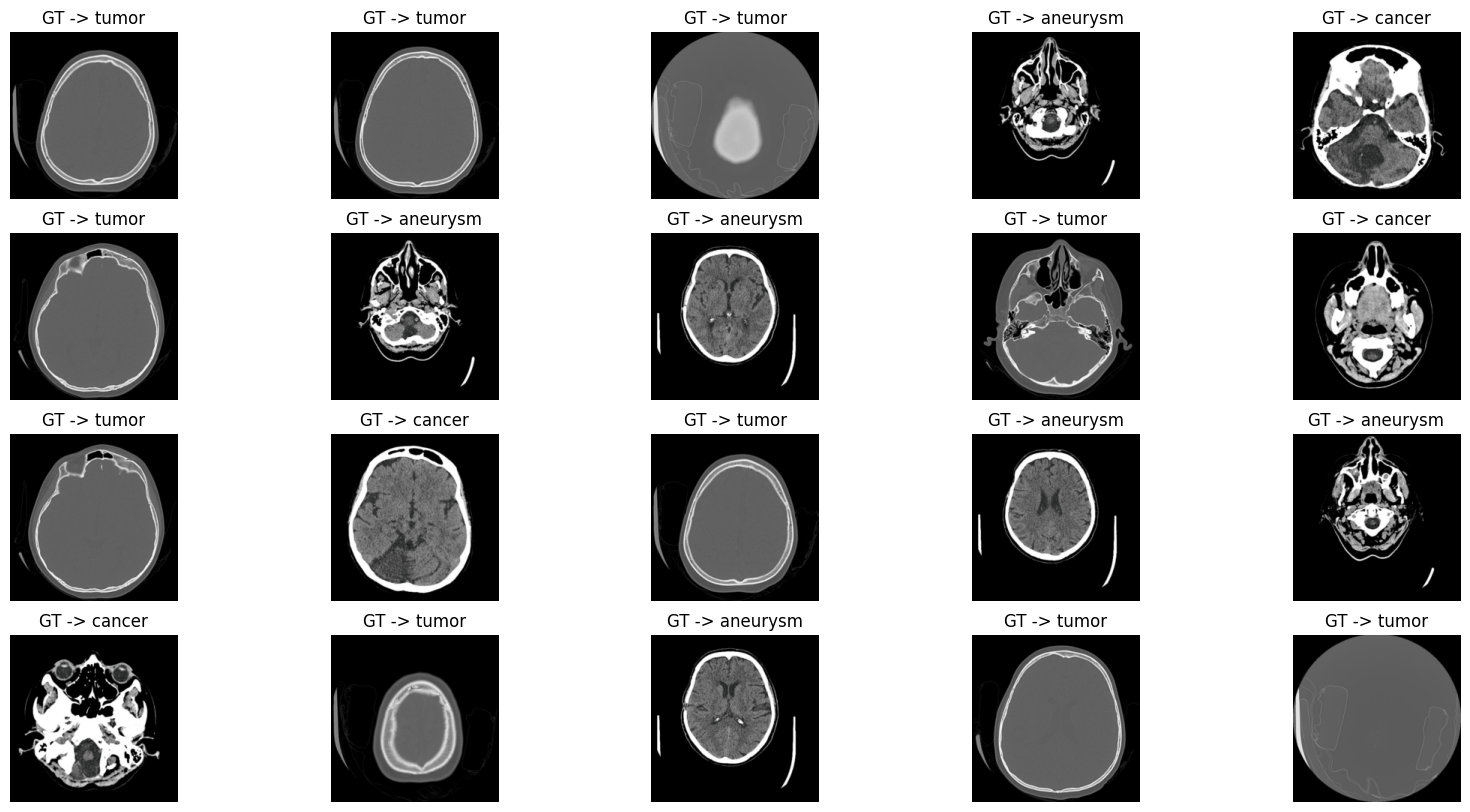

In [7]:
def tensor_2_pic(t, t_type = 'rgb'):   
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
   
    invTrans = gray_tfs if t_type == 'gray' else rgb_tfs
    
    return (invTrans(t)*255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == 'gray' else (invTrans(t)*255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)
import random
def visualize(data, num_pics, num_rows, class_names = None, cmap = None):
    assert cmap in ['rgb', 'gray']
    if cmap == 'rgb': cmap = 'viridis'
    plt.figure(figsize = (20,10))
    indexes = [random.randint(0, len(data)-1) for _ in range(num_pics)]
    for idx, indeks in enumerate(indexes):
        pic, gts = data[indeks]
        
        plt.subplot(num_rows, num_pics//num_rows, idx+1)
        if cmap: plt.imshow(tensor_2_pic(pic, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_pic(pic))
        plt.axis("off")
        if class_names is not None: plt.title(f"GT -> {class_names[gts]}")
        else: plt.title(f"GT -> {gts}")
            
visualize(tr_dl.dataset, num_pics = 20, num_rows = 4, cmap = 'rgb', class_names = list(ds.class_names.keys()))


C:\Users\Nodir\AppData\Local\Temp\ipykernel_17420\3139039909.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names, rotation = 60)


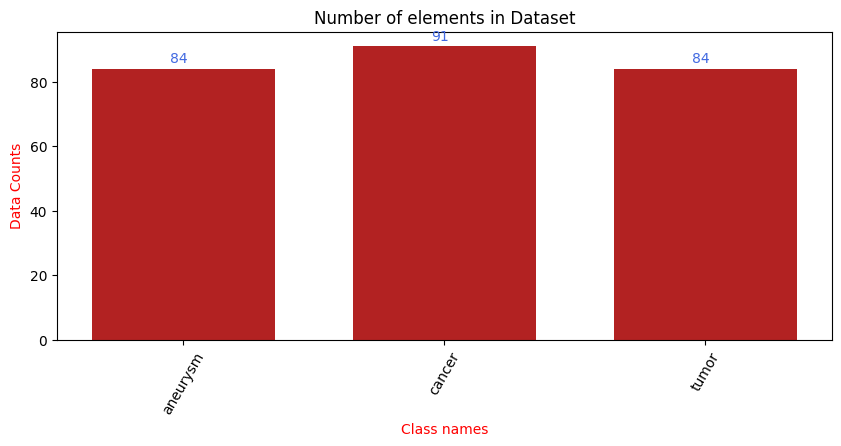

In [8]:
img_size = 224
tfs = T.Compose([T.ToTensor(), T.Normalize(std = std, mean = mean), T.RandomHorizontalFlip(), T.RandomRotation(15), T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), T.Resize((img_size, img_size))])
def data_analysis(data_path, transformations):
    ds = CustomDataset(data_path = data_path, transformations = tfs)
    data_quantity, text_width, width = ds.data_quantity, 0.05, 0.7
    text_height = 2
    class_names = list(data_quantity.keys()); counts = list(data_quantity.values())
    fig, ax = plt.subplots(figsize=(10, 4))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = 'firebrick')
    ax.set_xlabel("Class names", color = "red")
    ax.set_xticklabels(class_names, rotation = 60)
    ax.set(xticks = indices, xticklabels = class_names)
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title("Number of elements in Dataset")
    for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v) , color = "royalblue")
data_analysis(data_path = data_path, transformations = tfs)

In [9]:
from torch.nn import *
import timm
def model_train(tr_dl, model, loss_fn, optimizer, device):
    model.train()
    model.to(device)
    tr_loss, tr_acc = 0, 0

    for idx, batch in enumerate(tqdm(tr_dl, desc = "Train process...")):
        img, label = batch
        img = img.to(device)
        label = label.to(device)
        pred = model(img)
        loss = loss_fn(pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred_classes = torch.argmax(pred, dim = 1)
        acc = (torch.sum(pred_classes == label).item()/len(label)) * 100
        tr_acc += acc/len(tr_dl)
        tr_loss += loss.item() / len(tr_dl)
    return tr_loss, tr_acc

def model_val(vl_dl, model, loss_fn, optimizer, device):
    model.eval()
    model.to(device)
    vl_loss, vl_acc = 0, 0
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(vl_dl, desc = "Validation process...")):
            img, label = batch
            img = img.to(device)
            label = label.to(device)
            pred = model(img)
            loss = loss_fn(pred, label)
    
            pred_classes = torch.argmax(pred, dim=1)
            acc = (torch.sum(pred_classes == label).item()/len(label)) * 100
            vl_acc += acc/len(vl_dl)
            vl_loss += loss.item() / len(vl_dl.dataset)

        return vl_loss, vl_acc

def train(model, tr_dl, vl_dl, loss_fn, optimizer, device, epochs, model_dir ="best_model"):
    os.makedirs(model_dir, exist_ok = True)
    best_acc = 0
    patience = 0
    train_losses, train_acces = [], []
    vl_losses, vl_acces = [], []

    for epoch in range(epochs):
        print(f"{epoch+1}/{epochs}")
        tr_loss, tr_acc = model_train(tr_dl, model, loss_fn, optimizer, device)
        vl_loss, vl_acc = model_val(vl_dl, model, loss_fn, optimizer, device)
        train_losses.append(tr_loss)
        train_acces.append(tr_acc)
        vl_losses.append(vl_loss)
        vl_acces.append(vl_acc)

        if vl_acc > best_acc:
            best_acc = vl_acc
            torch.save(model, os.path.join(model_dir, "_brain_best_model.pth"))

        else: patience +=1
        if patience == 5:
            print(f"Best accuracy did not change during {patience} epochs. So EARLY STOPPING TRIGGERED!")
            print(f"Model/s best performance is - {best_acc}")
            break

        print(f"Train Loss -> {tr_loss:.2f}    | Train Accuracy -> {tr_acc:.2f}%")
        print(f"Val Loss   -> {vl_loss:.2f}    | Val Accuracy   -> {vl_acc:.2f}%")

    return train_losses, train_acces, vl_losses, vl_acces
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = timm.create_model("resnet34", pretrained = False, num_classes = len(ds.class_names)).to(device)
# model.head.fc = torch.nn.Sequential(
#     torch.nn.Linear(model.head.fc.in_features, 512),  # Reduce dimensionality before classification
#     torch.nn.BatchNorm1d(512),  # Batch Normalization layer
#     torch.nn.ReLU(),  # Activation function
#     torch.nn.Dropout(p=0.7),  # Dropout layer
#     torch.nn.Linear(512, len(ds.class_names))  # Final classification layer
# )
import torch.nn as nn

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),  # Reduce dimensionality
    nn.BatchNorm1d(512),  # Batch Normalization
    nn.ReLU(),  # Activation function
    nn.Dropout(p=0.8),  # Dropout for regularization
    nn.Linear(512, len(ds.class_names))  # Final classification layer
)

optimizer = torch.optim.Adam(params = model.parameters(), lr = 2e-4, weight_decay = 1e-4)
loss_fn = torch.nn.CrossEntropyLoss()
train_losses, train_acces, vl_losses, vl_acces = train(model = model, tr_dl = tr_dl, vl_dl= vl_dl, loss_fn=loss_fn, optimizer=optimizer, device = device, epochs = 50)

1/50


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.70it/s]


Train Loss -> 0.87    | Train Accuracy -> 64.02%
Val Loss   -> 0.09    | Val Accuracy   -> 50.00%
2/50


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.06it/s]


Train Loss -> 0.51    | Train Accuracy -> 80.82%
Val Loss   -> 0.09    | Val Accuracy   -> 33.33%
3/50


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


Train Loss -> 0.35    | Train Accuracy -> 88.67%
Val Loss   -> 0.08    | Val Accuracy   -> 50.00%
4/50


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.20it/s]


Train Loss -> 0.29    | Train Accuracy -> 89.80%
Val Loss   -> 0.06    | Val Accuracy   -> 83.33%
5/50


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.92it/s]


Train Loss -> 0.26    | Train Accuracy -> 94.53%
Val Loss   -> 0.04    | Val Accuracy   -> 91.67%
6/50


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


Train Loss -> 0.23    | Train Accuracy -> 96.48%
Val Loss   -> 0.02    | Val Accuracy   -> 91.67%
7/50


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.41it/s]


Train Loss -> 0.22    | Train Accuracy -> 93.14%
Val Loss   -> 0.01    | Val Accuracy   -> 91.67%
8/50


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.64it/s]


Train Loss -> 0.15    | Train Accuracy -> 98.44%
Val Loss   -> 0.01    | Val Accuracy   -> 100.00%
9/50


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.37it/s]

Best accuracy did not change during 5 epochs. So EARLY STOPPING TRIGGERED!
Model/s best performance is - 100.0


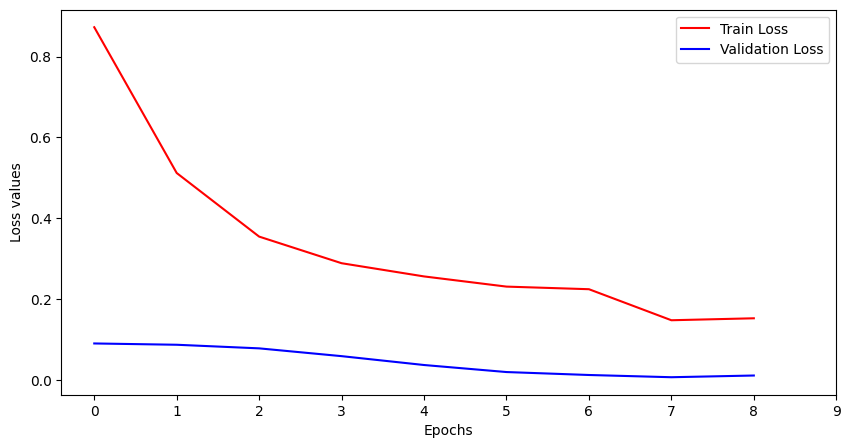

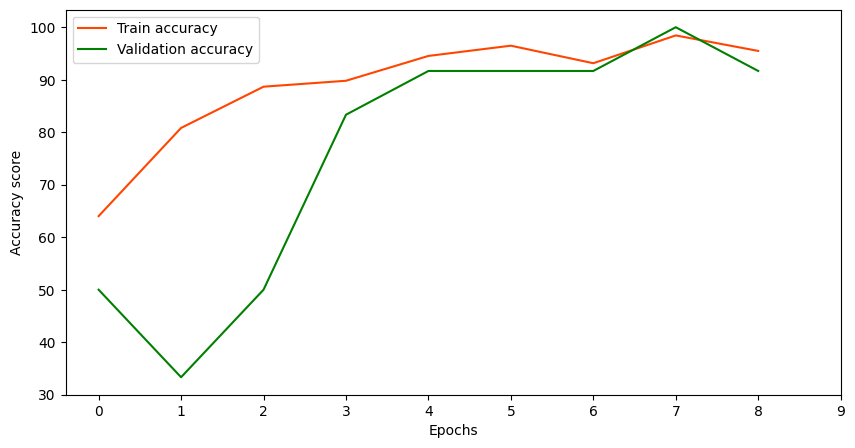

In [10]:
class PlotLearningcurves:
    
    def __init__(self, tr_loss, vl_loss, tr_acc, vl_acc):
        
        self.tr_loss, self.vl_loss, self.tr_acc, self.vl_acc = tr_loss, vl_loss, tr_acc, vl_acc

    def draw(self, array_1, array_2, label_1, label_2, color_1, color_2):
        
        plt.plot(array_1, label = label_1, c = color_1)
        plt.plot(array_2, label = label_2, c = color_2)

    def create_plot(self): plt.figure(figsize = (10, 5))

    def decorate(self, ylabel, xlabel = "Epochs"):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(ticks = np.arange(len(self.tr_acc) +1), labels = [i for i in range(len(self.tr_acc) + 1)])
        plt.legend()
        plt.show()
    def demonstrate(self):
        self.create_plot()
        self.draw(array_1 = self.tr_loss, array_2 = self.vl_loss, label_1 = "Train Loss", label_2 = "Validation Loss", color_1 = 'red', color_2 = 'blue'); self.decorate(ylabel = "Loss values")

        self.create_plot()
        self.draw(array_1 = self.tr_acc, array_2 = self.vl_acc, label_1 = "Train accuracy", label_2 = "Validation accuracy", color_1 = "orangered", color_2 = "green"); self.decorate(ylabel = "Accuracy score")

PlotLearningcurves(tr_loss = train_losses, vl_loss = vl_losses, tr_acc = train_acces, vl_acc = vl_acces).demonstrate()

In [11]:
import random
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2, seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import cv2
import seaborn as sns


C:\Users\Nodir\AppData\Local\Temp\ipykernel_17420\3221653005.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mode = torch.load("best_model/_brain_best_model.pth", map_l

Test accuracy is - 57.14


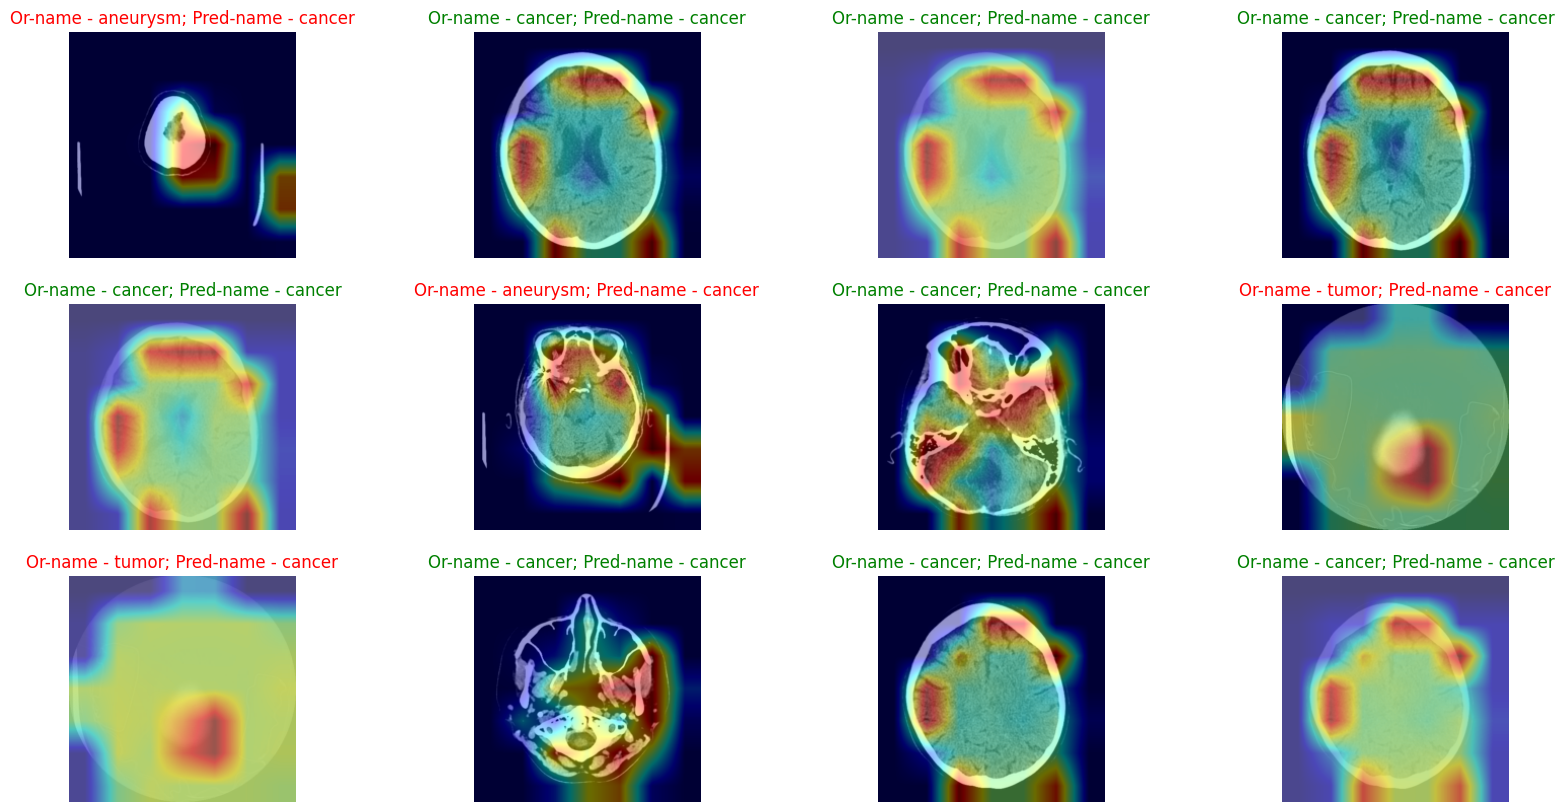

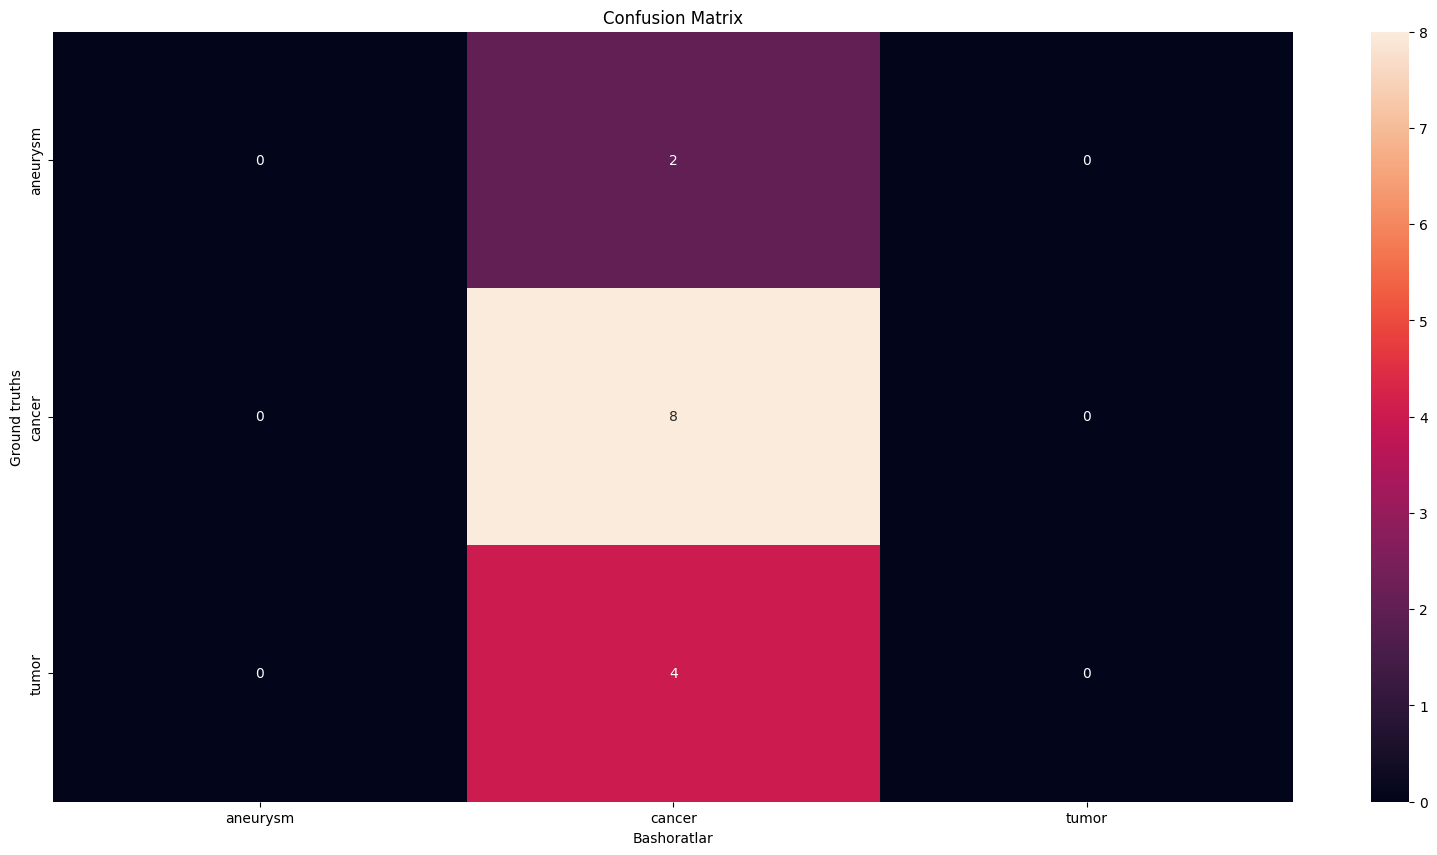

In [12]:
from pytorch_grad_cam import GradCAMPlusPlus

class Denormalization:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std): t.mul_(s).add_(m)
        return tensor

class Inference:
    def __init__(self, model, class_names, device, img_size = 224, mean=mean, std=std):
        self.img_size = img_size
        self.denormalize = Denormalization(std = std, mean=mean)
        self.model = model
        self.class_names = class_names
        self.device = device

    def tensor_2_img(self, tensor):
        tensor = self.denormalize(tensor)
        tensor = tensor.permute(1,2,0)
        return (tensor.cpu().numpy() * 255).astype(np.uint8)

    def gradcam(self, pic):
        # cam = GradCAMPlusPlus(self.model, target_layers = [model.features[-1]], use_cuda = "cuda")
        cam = GradCAMPlusPlus(self.model, target_layers=[self.model.layer4[-1]], use_cuda="cuda")

        final_cam = cam(pic.unsqueeze(0))[0, :]
        return final_cam

    def inference(self, model,ts_dl, device, num_of_pics, num_rows):
        images, predictions, pred_classes, ground_truth = [], [], [], []
        acc = 0
        count = 1
        self.model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(tqdm(ts_dl, desc = "Test process...")):
                pic, label = batch
                pic = pic.to(device)
                label = label.to(device)
                preds = self.model(pic)
                pred_class = torch.argmax(preds, dim=1)
                acc += (pred_class == label).sum().item()

                images.append(pic[0])
                predictions.append(preds[0])
                pred_classes.append(pred_class[0].item())
                ground_truth.append(label[0].item())

            print(f"Test accuracy is - {(acc/len(ts_dl.dataset)*100):.2f}")

        plt.figure(figsize = (20,10))
        indexes = [random.randint(0, len(images) - 1) for _ in range(num_of_pics)]
        for idx, element in enumerate(indexes): # element emas element
            
            pic = self.tensor_2_img(images[element].squeeze())
            pred_element = (pred_classes[element])
            ground_truth_element = (ground_truth[element])

            plt.subplot(num_rows, num_of_pics // num_rows, count)
            count += 1
            plt.imshow(pic, cmap = "gray")
            plt.axis("off")

            cam_pic = self.gradcam(images[element])
            tablot = show_cam_on_image(pic / 255, cam_pic, image_weight = 0.4, use_rgb = True)
            plt.imshow(cv2.resize(tablot, (self.img_size, self.img_size), interpolation = cv2.INTER_LINEAR), alpha = 0.7, cmap = "jet")
            plt.axis("off")

            pred = predictions[element]
            if pred.dim() == 1: pred = pred.unsqueeze(0)

            if self.class_names:
                label_name = self.class_names[ground_truth_element]
                pred_name = self.class_names[pred_element]
                col = "green" if pred_name == label_name else "red"
                plt.title(f"Or-name - {label_name}; Pred-name - {pred_name}", color = col)
        plt.figure(figsize=(20, 10))   
        cm = confusion_matrix(ground_truth, pred_classes)
        sns.heatmap(cm, annot=True, xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Bashoratlar")
        plt.ylabel("Ground truths")
        plt.show()               
                


device = "cuda" if torch.cuda.is_available() else "cpu"

model = timm.create_model(model_name = "resnet34", pretrained = False, num_classes = len(ds.class_names)).to(device)
mode = torch.load("best_model/_brain_best_model.pth", map_location=device)
mode.eval()
drawer = Inference(model=model, device=device, class_names=list(ds.class_names.keys()), img_size=224)

drawer.inference(model= model, ts_dl = ts_dl, device=device, num_of_pics=12, num_rows=3)